# Group project (Master)

Analysis of competitiveness of different energy production technologies in Danish Electricity Market

## Modeling of current energy system

### Data gathering and analysis

Latest energy statistics reports available is for 2018. Thereforte, all data used is dated to year 2018.

Hourly consumption, production, as well as wind energy production data available from https://www.nordpoolgroup.com/historical-market-data/

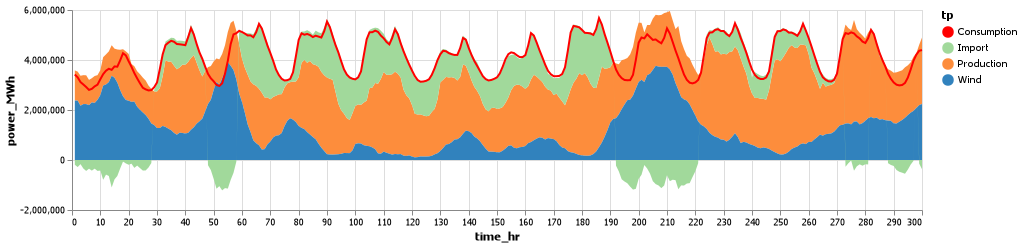

In [69]:
using CSV, VegaLite, DataFrames, Statistics

consum = CSV.read("consumption-dk-areas_2018_hourly.csv", DataFrame)
produc = CSV.read("production-dk-areas_2018_hourly.csv", DataFrame)
wind   = CSV.read("wind-power-dk_2018_hourly.csv", DataFrame)
exp    = CSV.read("exchange-per-country_2018_hourly.csv", DataFrame)
solar  = CSV.read("solarpv2018.csv", DataFrame)


n = 300

#production with wind substracted
dif = produc[1:n,"DK"]-wind[1:n,"DK"]

data = vcat(DataFrame(time_hr=collect(1:n),power_MWh = consum[1:n,"DK"]*1000, tp = "Consumption",source = 2),           
            DataFrame(time_hr=collect(1:n),power_MWh = dif*1000, tp ="Production",source = 1),
            DataFrame(time_hr=collect(1:n),power_MWh = wind[1:n,"DK"]*1000, tp = "Wind",source = 1),
            DataFrame(time_hr=collect(1:n),power_MWh = exp[1:n,"DK"]*1000, tp = "Import",source = 1))

#Plotting data
data |>
@vlplot(width=850, hieght=700)+
@vlplot(mark=:area, x=:time_hr, y={:power_MWh,stack=:zero},color=:tp,transform=[{filter="datum.source==1"}]) +
@vlplot(mark=:line, x=:time_hr, y=:power_MWh, transform=[{filter="datum.source==2"}],
    color={:tp,
    scale={range = ["red","#a1d99b","#fd8d3c","#3182bd"]}})

+ Total energy demand is covered by the combination of local energy production and import of energy from neighbouring countries
+ Big part of electric energy is covered by the wind power production
+ The difference is covered by the combination of renewable and non-renewable sources

Share of production technologies in energy mix can be found in Energy Statistics Report for 2018 by Danish Energy Agency (https://ens.dk/en/our-services/statistics-data-key-figures-and-energy-maps/annual-and-monthly-statistics) 

For the simulation all units could be represented in a model, but only most feasable units are dispatched to cover difference between wind and consumption.

### Modeling
Energy system could be modeled based on the data from above. In this case the system would consist of already deployed units and investment opportunities what will further optimize the system (Minimize costs). Wind production will be substracted from consumption for each of the time steps and optimization for mix of technologies covering the difference will be made.

Additional information required:
+ Operational prices for existing power plants based on type of plant/fuel
+ Investment prices (price per KW) for further investments 


In [70]:
p = 1000
inp = DataFrame(Name            = ["Solar PV","Wind Onshore","Wind Offshore","Biogas","Brown coal","Hard coal","CCGT","GT"],
                Capex_avg       = [700,1750,3900,3000,1900,1650,950,500]*p,    #investment cost EUR/kW (nominal capacity)
                Lifetime        = [25,25,25,30,40,40,30,30],                   #Years
                Opex_of_capex   = [0.025,0,0,0.04,0,0,0,0],                    #EUR/kw % of CAPEX
                Opex_fix        = [0,30,100,0,36,32,22,20]*p,                  #EUR/Kw
                Opex_var        = [0,0.005,0.005,0,0.005,0.005,0.004,0.003]*p, #EUR/kwh
                Fuel_price      = [0,0,0,30.3,1.8,9.6,21,21],                  #EUR/MWh heat
                Fuel_eff        = [1,1,1,0.4,0.45,0.46,0.6,0.6])               #el. eng. % of heat en

,Name,Capex_avg,Lifetime,Opex_of_capex,Opex_fix,Opex_var,Fuel_price
,String,Int64,Int64,Float64,Int64,Float64,Float64
1,Solar PV,700000,25,0.025,0,0.0,0.0
2,Wind Onshore,1750000,25,0.0,30000,5.0,0.0
3,Wind Offshore,3900000,25,0.0,100000,5.0,0.0
4,Biogas,3000000,30,0.04,0,0.0,30.3
5,Brown coal,1900000,40,0.0,36000,5.0,1.8
6,Hard coal,1650000,40,0.0,32000,5.0,9.6
7,CCGT,950000,30,0.0,22000,4.0,21.0
8,GT,500000,30,0.0,20000,3.0,21.0


### Estiamtion of the capacity factor

In [71]:
T = size(consum)[1]
#capacity factor
c = []
append!(c, wind[i,"DK"]/maximum(wind[1:T,"DK"]) for i=1:T)    #capacity factor
println("")

### Mathematical  formualtion

**Variables:** 
<br> $p_{it}$ production of technology i in time unit t
<br> $p_i^{max}$ max power production of unit i

**Parameters:**
<br> $a$ - operations varaible cost [EUR/KWh]
<br> $f$ - fuel price [EUR/KWh]
<br> $e$ - fuel efficiency [\$]
<br> $b$ - CAPEX [EUR/KWh]
<br> $l$ - expected system lifetime [yr.]
<br> $o$ - fixed operational expenses [EUR/kw % of CAPEX]
<br> $k$ - fixed operational expenses [EUR/kw]
<br> $d$ - demand for power [Mw]
<br> $c$ - capacity factor 

**Objective:** 
<br>to minimize cost of electricity

$$Z = \dfrac{\sum_{t=1}^{T}\sum_{i=1}^{n}p_{it} \left( a_i+ f_ie_i\right) + 
\sum_{i=1}^{n} \dfrac{p^{max}_{i}}{l_{i}}\left(b_i(1+o_i)+k_{i} \right)}{\sum_{t=1}^{T}d_t} \tag{1}$$

$$p_{it}\leq p^{max}_i \tag{2} $$

$$p_{wt} = p^{max}_w c_{wt} \tag{3} $$

$$\sum_{t=1}^{T}\sum_{i=1}^{I} p_{it} \geq d_t \tag{4} $$

$$p_{it},p_{i}^{max} \geq 0 $$

## Main

In [192]:
#share of renewables
ren_s = [0,0.6,0.8,0.95,1]

Per_tech_ren = DataFrame(
                         Technology     = String[],
                         Capacity_MWh   = Float64[],
                         Utilization    = Float64[],
                         CAPEX_EUR      = Float64[], 
                         OM_EUR         = Float64[],
                         Share_ren      = String[])

Totals_ren   = DataFrame(Share_ren      = Float64[],
                         LCOE           = Float64[], 
                         Production_MWh = Float64[], 
                         Demand_MWh     = Float64[], 
                         CAPEX_t_EUR    = Float64[], 
                         OM_t_EUR       = Float64[])

for share in ren_s
    append!(Totals_ren, optimize(share)[1])
    append!(Per_tech_ren, optimize(share)[2])
    plotSeries(optimize(share)[3],share)
end

#ploting   
plotTechnology(Per_tech_ren)

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\anton\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\anton\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\anton\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\anton\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage ty

## Mathematical model

In [193]:
using CSV, JuMP, GLPK

#Declaration of data frames

function optimize(x)

n = size(inp)[2]
T = 1000
M = 10*maximum(consum[1:T,"DK"])

m = Model(with_optimizer(GLPK.Optimizer))

@variable(m,p[i=1:n,t=1:T] >= 0)        #power per technology
@variable(m,pmax[i=1:n] >= 0)           #power per technology
@variable(m,u[i=1:n], Bin)         #controling number of technologies

@objective(m, Min, (sum(p[i,t]*                      (inp[i,"Opex_var"] + inp[i,"Fuel_price"]*inp[i,"Fuel_eff"])            for i=1:n for t=1:T) +
                    sum((pmax[i]/inp[i,"Lifetime"])* (inp[i,"Capex_avg"]*(1+inp[i,"Opex_of_capex"])+inp[i,"Opex_fix"])      for i=1:n))/
                    sum(consum[t,"DK"]                                                                                      for t=1:T))

@constraint(m, Solar[t=1:T],                 p[1,t] <= pmax[1]*solar[t,"DK"])                  #Solar
@constraint(m, OnShoreWind[t=1:T],           p[2,t] == pmax[2]*c[t])             #Onshore wind
@constraint(m, OffShoreWind[t=1:T],          p[3,t] == pmax[3]*c[t])             #Offshore wind
@constraint(m, NotIntermittent[i=4:n,t=1:T], p[i,t] <= pmax[i])                  #not intermittent

@constraint(m, Demand[t=1:T], sum(p[i,t] for i=1:n) >= consum[t,"DK"]) #Demand
                
#TEMPORARY limiting use of solar
#@constraint(m, pmax[1]  <= 2000)
                
#limiting number of technologies
@constraint(m,[i=1:n], p[i] <=M*u[i])
@constraint(m, sum(u[i] for i=1:n) <= 3)           #number of technologies allowed
                    
#Increasing share of renewables
@constraint(m, sum(p[i,t] for i=[1,2,3] for t=1:T) == x*sum(consum[:,"DK"]))
                        
optimize!(m)
                                        
#End of model. Data expoerting ->
                                        
T_series = DataFrame(Time_hr       = collect(1:T), 
                     Solar_PV      = JuMP.value.(p[1,1:T]),
                     Wind_offshore = JuMP.value.(p[2,1:T]),
                     Wind_onshore  = JuMP.value.(p[3,1:T]),
                     Biogas        = JuMP.value.(p[4,1:T]),
                     Coal_brown    = JuMP.value.(p[5,1:T]),
                     Coal_hard     = JuMP.value.(p[6,1:T]),
                     CCGT          = JuMP.value.(p[7,1:T]),
                     GT            = JuMP.value.(p[8,1:T]),
                     Consumption   = consum[1:T,"DK"])                                        

Totals   = DataFrame(Share_ren      = x,
                     LCOE           = JuMP.objective_value(m), 
                     Production_MWh = sum( JuMP.value.(p[i,t]) for i=1:n for t=1:T),
                     Demand_MWh     = sum(consum[1:T,"DK"]),
                     CAPEX_t_EUR    = sum(JuMP.value.(pmax[i])*inp[i,"Capex_avg"] for i=1:n),
                     OM_t_EUR       = sum(JuMP.value.(p[i,t])*(inp[i,"Opex_var"]+
                                          inp[i,"Fuel_price"]*inp[i,"Fuel_eff"])+
sum((JuMP.value.(pmax[i])/inp[i,"Lifetime"])*(inp[i,"Capex_avg"]*inp[i,"Opex_of_capex"]+inp[i,"Opex_fix"])) 
                                        for i=1:n for t=1:T))                                                                   
                                                                    
Per_tech = DataFrame(
                     Technology     = String[],
                     Capacity_MWh   = Float64[],
                     Utilization    = Float64[],
                     CAPEX_EUR      = Float64[], 
                     OM_EUR         = Float64[],
                     Share_ren      = String[])                                                                    

for i = 1:n
    append!(Per_tech, DataFrame(
                                Technology           = inp[i,"Name"],
                                Capacity_MWh   = JuMP.value.(pmax[i]), 
                                Utilization    = mean(sum(JuMP.value.(p[i,t]) for t=1:T))/JuMP.value.(pmax[i]),
                                CAPEX_EUR      = JuMP.value.(pmax[i])*inp[i,"Capex_avg"], 
                                OM_EUR         = sum(JuMP.value.(p[i,t])*(inp[i,"Opex_var"]+
                                                     inp[i,"Fuel_price"]*inp[i,"Fuel_eff"])+
                                                     sum((JuMP.value.(pmax[i])/inp[i,"Lifetime"])*(inp[i,"Capex_avg"]*inp[i,"Opex_of_capex"]+inp[i,"Opex_fix"])) for t=1:T),
                                Share_ren      = string(x)))
end
                                                                
return Totals,Per_tech,T_series
end
                                                                                                                          

optimize (generic function with 1 method)

### Visualization

In [191]:
#Displaying results

#Time series
function plotSeries(x,y)
    
    d = 500   
    x[1:d,:] |>
    stack |>         #Stacking data
    @vlplot(width=850, hieght=700)+
    @vlplot(mark=:area, x=:Time_hr, y={:value,stack=:zero},color={:variable,
        scale={scheme="category20b"},
        legend={title="Technologies"}
        }
    )+
    @vlplot(mark=:line, x=:Time_hr, y=:Consumption) |> save("Results/$y _Series.png")

end


#Bars chart
function plotTechnology(x)
    x |>
    @vlplot(
        height=500,
        width =300,
        mark={
            :bar,
            cornerRadiusTopLeft = 15,
            cornerRadiusTopRight= 15
        },
        x=:Share_ren,
        y=:Capacity_MWh,
        color={
            :Technology
        }
    ) |> save("Results/BarChart.png")

    #Donat plots
    for i= 1:size(ren_s)[1]   
        df = filter(row -> row[:Share_ren ] == string(ren_s[i]), x)   

    n = ren_s[i]
        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'Capacity_MWh'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology"},
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=120}, text="value:n",title= "Capacity_MWh") |> save("Results/$n _Capacity_MWh.png")# 

        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'Utilization'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology"},
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=120}, text="value:n",title= "Utilization") |> save("Results/$n _Utilization.png")

        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'CAPEX_EUR'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology"},
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=120}, text="value:n",title= "CAPEX_EUR") |> save("Results/$n _CAPEX_EUR.png")
    
        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'OM_EUR'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology"},
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=120}, text="value:n",title= "OM_EUR") |> save("Results/$n _OM_EUR.png")
    
    end
end


plotTechnology (generic function with 1 method)

In [9]:
println("Cost of electricity levelzied: ", JuMP.objective_value(m)/1000," EUR/kWh" )    # Levelized 
#println("Cost of electricity per year: ", JuMP.objective_value(m)/sum(consum[1:T,"DK"])/1000," EUR/kWh" )
println("Total power produced: ", sum( JuMP.value.(p[i,t]) for i=1:n for t=1:T)," MWh")
println("Total power demand: "  , sum(consum[1:T,"DK"]), " MWh")
println("Initial investment: ",    sum(JuMP.value.(pmax[i])*inp[i,"Capex_avg"] for i=1:n)," EUR" )
println("Operational costs: ",     sum(JuMP.value.(p[i,t])*(inp[i,"Opex_var"]+
                                                            inp[i,"Fuel_price"]*inp[i,"Fuel_eff"])+
                                                      sum((JuMP.value.(pmax[i])/inp[i,"Lifetime"])*(inp[i,"Capex_avg"]*inp[i,"Opex_of_capex"]+inp[i,"Opex_fix"])) for i=1:n for t=1:T))
                                                                                                        
println("")
for i=1:n
    println(inp[i,"Name"])
    println("Required capacity: ", JuMP.value.(pmax[i]), " MWh")
    println("Investments: ", JuMP.value.(pmax[i])*inp[i,"Capex_avg"], " EUR" )
    println("Operational costs: ",sum(JuMP.value.(p[i,t])*(inp[i,"Opex_var"]+
                                                           inp[i,"Fuel_price"]*inp[i,"Fuel_eff"])+
                                                           sum((JuMP.value.(pmax[i])/inp[i,"Lifetime"])*(inp[i,"Capex_avg"]*inp[i,"Opex_of_capex"]+inp[i,"Opex_fix"])) for t=1:T))
println("")

end

LoadError: UndefVarError: m not defined

WARN Missing type for channel "color", using "nominal" instead.
WARN Missing type for channel "color", using "nominal" instead.


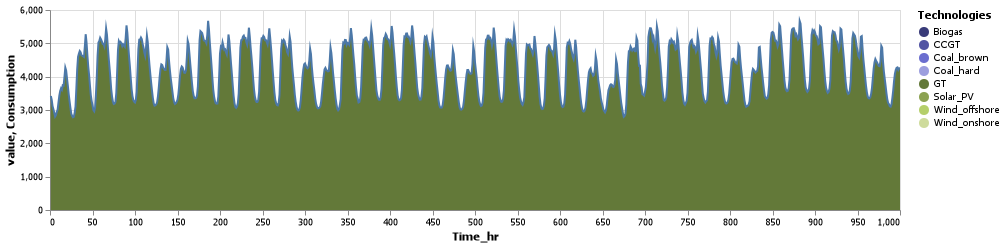

In [36]:
d = T   #plotting range
#Plotting data
Data[1:d,:] |>
stack |>         #Stacking data
@vlplot(width=850, hieght=700)+
@vlplot(mark=:area, x=:Time_hr, y={:value,stack=:zero},color={:variable,
    scale={scheme="category20b"},
    legend={title="Technologies"}
    }
)+
@vlplot(mark=:line, x=:Time_hr, y=:Consumption)

### Sensitivity analysis

In [28]:
#Get dual value
println(getdual(NotIntermittent[4,1000]))

#Get shadow prices
JuMP. shadow_price.(NotIntermittent[4,1000])

0.0


# Extension 1 (Storage technologies)


Storage technologies
The extension will include options for investing into strage technologies such as Li-ion batteries or convesion of electical energy into fuels such as H2 or Biomethanol. Furter on fossil fuels will be removed to estimate amount of storage required to achieve fully renewable electricity production by 2050. 

### Further model improvements

Ideas for further model improvements:
+ Green transition requirements (100% of electric energy from Renewables)
+ Backup generation requirements
+ Including price of fuel and CO2 tax
+ Energy import and export
+ Subsidy for renewables
+ Storage 
+ Sell/buy 
+ Electric cars
+ Heat

# Name of extension

## Formualtion
waht, why we do this
what are articles/resources that support the idea

## Mathematical model
constraint

## Implementation
coding
constraints, varaibles, data (parameters)

## Sensitivity analysis

###  Sub-conclusion
